In [ ]:
# Agenda: Importing essential libraries for data manipulation, visualization, preprocessing, model building, and performance evaluation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

In [ ]:
# Agenda: Load the dataset, handle missing values, and display dataset information along with basic summary.
df = pd.read_csv(r"C:\Users\ekaushik\Desktop\Virtual Index Cards (DSE511)\CardioDS.csv")
df = df.dropna()
print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 288
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       289 non-null    object 
 1   sex       289 non-null    float64
 2   cp        289 non-null    float64
 3   trtbps    289 non-null    float64
 4   chol      289 non-null    float64
 5   fbs       289 non-null    float64
 6   restecg   289 non-null    float64
 7   thalachh  289 non-null    float64
 8   exng      289 non-null    float64
 9   oldpeak   289 non-null    float64
 10  slp       289 non-null    float64
 11  caa       289 non-null    float64
 12  thall     289 non-null    float64
 13  output    289 non-null    float64
dtypes: float64(13), object(1)
memory usage: 33.9+ KB
None

Statistical Summary:
              sex          cp      trtbps        chol         fbs     restecg  \
count  289.000000  289.000000  289.000000  289.000000  289.000000  289.000000   
mean     0.678201 

In [10]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')


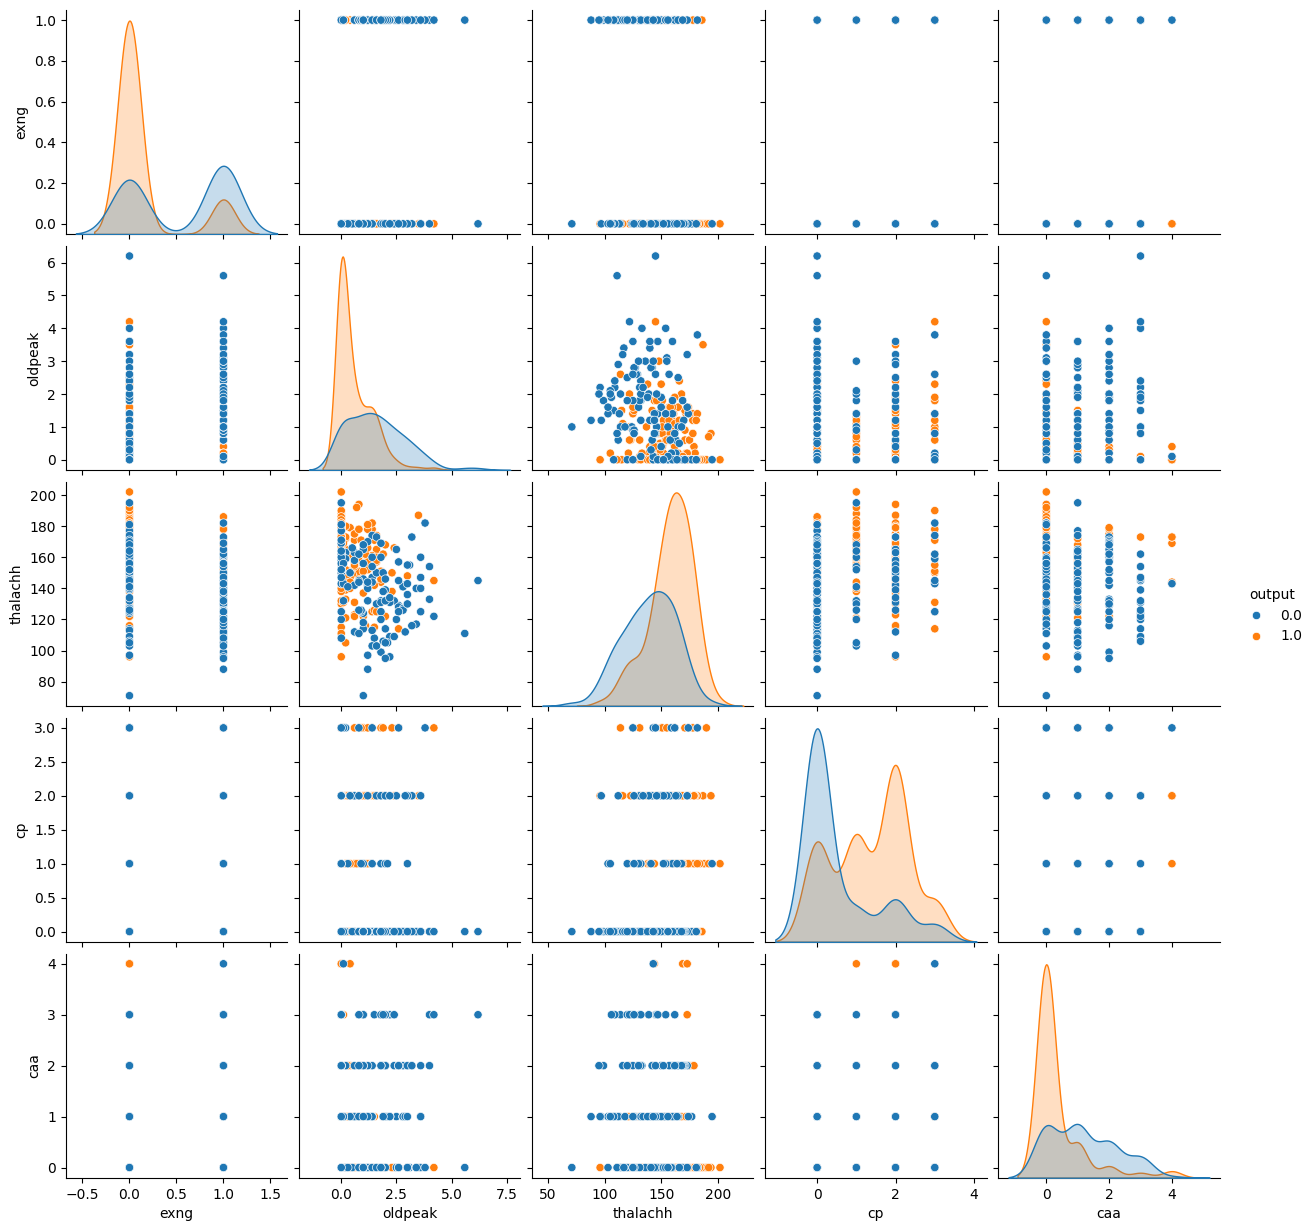

In [ ]:
# Identify top correlated features with the target variable and visualize their pairwise relationships using pair plots.
top_features = df.corr()['output'].abs().sort_values(ascending=False).index[1:6]

sns.pairplot(df[top_features.tolist() + ['output']], hue='output')
plt.show()

In [ ]:
# Agenda: Generate polynomial interaction features and encode categorical variables to prepare dataset for modeling.

from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df.drop('output', axis=1))

feature_names = poly.get_feature_names_out(df.drop('output', axis=1).columns)

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = pd.DataFrame(X_poly, columns=feature_names)
Y = df['output']

print("Shape of X_poly:", X_poly.shape)
print("First 5 feature names:", feature_names[:5])
X.head()

Shape of X_poly: (289, 91)
First 5 feature names: ['age' 'sex' 'cp' 'trtbps' 'chol']


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,...,exng oldpeak,exng slp,exng caa,exng thall,oldpeak slp,oldpeak caa,oldpeak thall,slp caa,slp thall,caa thall
0,26.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,...,0.0,0.0,0.0,0.0,0.0,0.0,2.3,0.0,0.0,0.0
1,2.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
2,7.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,...,0.0,0.0,0.0,0.0,2.8,0.0,2.8,0.0,4.0,0.0
3,21.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,...,0.0,0.0,0.0,0.0,1.6,0.0,1.6,0.0,4.0,0.0
4,22.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,...,0.6,2.0,0.0,2.0,1.2,0.0,1.2,0.0,4.0,0.0


In [15]:
# Agenda: Scaling and train-test split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
# Agenda: Set up hyperparameter grids and cross-validation for Random Forest, Gradient Boosting, and SVM classifiers using GridSearchCV.
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=cv, scoring='roc_auc')
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=cv, scoring='roc_auc')
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=cv, scoring='roc_auc')

In [ ]:
# Agenda: Create and train a stacking ensemble model combining Random Forest, Gradient Boosting, and SVM, with RidgeClassifier as the meta-learner.
estimators = [('rf', rf_grid), ('gb', gb_grid), ('svm', svm_grid)]
stack_model = StackingClassifier(estimators=estimators, final_estimator=RidgeClassifier(), cv=cv)
stack_model.fit(X_train, Y_train)

,estimators,"[('rf', ...), ('gb', ...), ...]"
,final_estimator,RidgeClassifier()
,cv,StratifiedKFo... shuffle=True)
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [ ]:
#Agenda: Evaluate stacked model performance on the test set.
stack_model.fit(X_train, Y_train)

y_pred = stack_model.predict(X_test)

try:
    y_scores = stack_model.decision_function(X_test)
except AttributeError:
    y_scores = stack_model.predict_proba(X_test)[:, 1]

print("\nStacked Model Results:")
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))

roc_auc = roc_auc_score(Y_test, y_scores)
print("ROC-AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(Y_test, y_scores)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


Stacked Model Results:
Accuracy: 0.7931034482758621
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.76      0.76        25
         1.0       0.82      0.82      0.82        33

    accuracy                           0.79        58
   macro avg       0.79      0.79      0.79        58
weighted avg       0.79      0.79      0.79        58

ROC-AUC: 0.9175757575757576
Precision-Recall AUC: 0.9293235949401056


##### Stacked model achieved 79.3% accuracy with balanced precision and recall. ROC-AUC 0.918 and PR-AUC 0.929 indicate strong overall performance and reliable predictions.